In [1]:
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
#Load and Truncate Data
df_2019 = pd.read_csv("data/2019_WEP.csv",usecols=['WEP ($/MWh)'])
time_index = pd.date_range(start='1/1/2019 00:00:00', end='31/12/2019 23:30:00', freq="30min")
df_2019.index = time_index
std = df_2019['WEP ($/MWh)'].std()
mean = df_2019['WEP ($/MWh)'].mean()
df_2019['WEP ($/MWh)'].loc[df_2019['WEP ($/MWh)'] > mean + 3*std] = mean + 3*std

In [4]:
#Convert to supervised and shuffle
dataset = series_to_supervised(df_2019,336,48).sample(frac=1)

(17137, 384)
Feature shape: (336,)
(17137, 336)
(17137, 48)
Train on 13709 samples, validate on 3428 samples
Epoch 1/10
13709/13709 - 2s - loss: 16.7493 - mean_squared_error: 1084.5160 - val_loss: 13.5383 - val_mean_squared_error: 828.1228
Epoch 2/10
13709/13709 - 2s - loss: 13.0197 - mean_squared_error: 802.2628 - val_loss: 12.7434 - val_mean_squared_error: 815.6340
Epoch 3/10
13709/13709 - 1s - loss: 12.4559 - mean_squared_error: 780.7091 - val_loss: 12.3705 - val_mean_squared_error: 777.5724
Epoch 4/10
13709/13709 - 1s - loss: 12.4085 - mean_squared_error: 776.3137 - val_loss: 12.1101 - val_mean_squared_error: 787.0121
Epoch 5/10
13709/13709 - 1s - loss: 12.0177 - mean_squared_error: 763.1234 - val_loss: 12.1311 - val_mean_squared_error: 746.1881
Epoch 6/10
13709/13709 - 1s - loss: 11.8299 - mean_squared_error: 754.4236 - val_loss: 12.2433 - val_mean_squared_error: 803.6346
Epoch 7/10
13709/13709 - 1s - loss: 11.6818 - mean_squared_error: 748.9665 - val_loss: 11.6973 - val_mean_squa

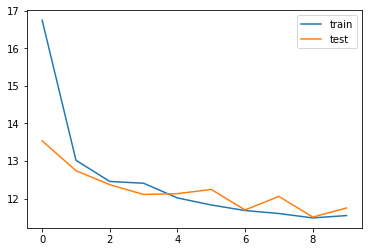

In [5]:
print(dataset.shape)

# Separate features and targets
X = dataset.iloc[:, :-48]
Y = dataset.iloc[:, -48:]

# Set the input shape
input_shape = (336,)
print(f'Feature shape: {input_shape}')

print(X.shape)
print (Y.shape)

# Create the model
model = Sequential()
model.add(Dense(240, input_shape=input_shape, activation='relu'))
model.add(Dense(240, activation='relu'))
model.add(Dense(48, activation='linear'))

# Configure the model and start training
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])

history=model.fit(X, Y, epochs=10, batch_size=64, verbose=2, validation_split=0.2)

print (history.history['val_mean_squared_error'][9])

model.save("model_240_240_MLP_10_64.h5")
print("Saved model to disk")

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

